# CW 10 Part 1
In this coursework, we aim to image a phase object after propagating for some distance in free space by using off-axis holography. 

You are given the code for loading an image, padding with zeroes and propagating for an arbitrary distance.

Then, the next steps are to
- interfere this field with an off-axis reference plane wave
- record the intensity
- extract incoming complex field by Fourier transforming and bringing the interference term to the center
- and propagate back

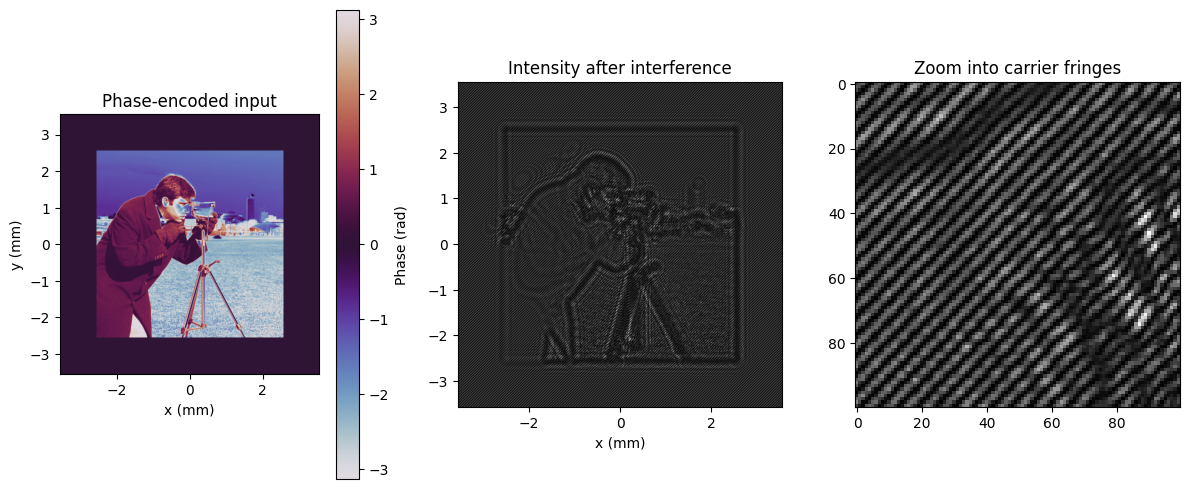

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.fft import fft2, ifft2, fftshift

img = data.camera()
# pad the image
img = np.pad(img, ((100, 100), (100, 100)), mode='constant')
img = img / 255.0  # Normalize to [0, 1]
ny, nx = img.shape
dx = dy = 10e-6  # Pixel size (10 microns)


phase = img * 2 * np.pi  # scale to [0, 2pi]
field = np.exp(1j * phase)  # complex field with phase encoding

def fresnel_propagate(u0, z, wavelength, dx):
    k = 2 * np.pi / wavelength
    ny, nx = u0.shape
    fx = np.fft.fftfreq(nx, d=dx)
    fy = np.fft.fftfreq(ny, d=dx)
    FX, FY = np.meshgrid(fx, fy)
    H = np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    U0 = fft2(u0)
    Uz = ifft2(U0 * H)
    return Uz

wavelength = 633e-9  
z = 0.03  # propagation distance in meters
propagated_field = fresnel_propagate(field, z, wavelength, dx)



theta_x = 3 * np.pi / 180  # 3 degrees off-axis
theta_y = 3 * np.pi / 180  # 3 degrees off-axis

kx = (2 * np.pi / wavelength) * np.sin(theta_x)
ky = (2 * np.pi / wavelength) * np.sin(theta_y)

x = (np.arange(nx) - nx // 2) * dx
y = (np.arange(ny) - ny // 2) * dy
X, Y = np.meshgrid(x, y)
plane_wave = np.exp(1j * ((kx * X)+ (ky * Y)) )

interfered = propagated_field + plane_wave
intensity = np.abs(interfered) ** 2

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Phase-encoded input")
plt.imshow(np.angle(field), cmap='twilight', extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.colorbar(label="Phase (rad)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

plt.subplot(1, 3, 2)
plt.title("Intensity after interference")
plt.imshow(intensity, cmap='gray', extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.xlabel("x (mm)")

plt.subplot(1, 3, 3)
plt.title("Zoom into carrier fringes")
plt.imshow(intensity[200:300, 200:300], cmap='gray')
plt.tight_layout()
plt.show()


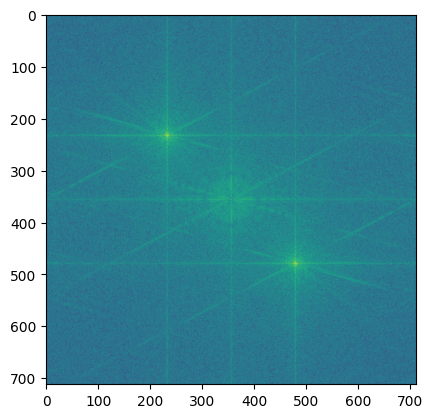

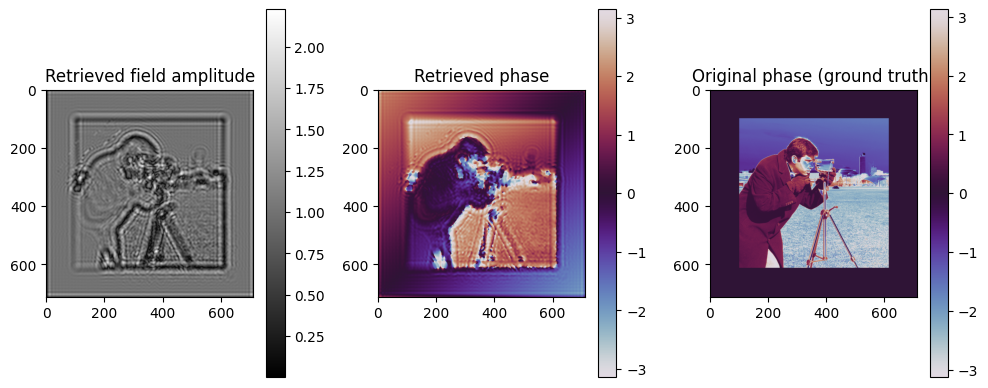

In [43]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(intensity)))))# Step 8: Extract the carrier frequency component from interferogram
# FFT of the intensity
I_fft = fftshift(fft2(intensity))
magnitude_spectrum = np.abs(I_fft)

# Find the off-axis carrier peak manually or set it
# Here we select a fixed region (this could be automated with peak finding)
cy, cx = ny // 2, nx // 2
center_order= 233
range = 64
off_axis_peak = I_fft[center_order-range:center_order+range,center_order-range:center_order+range]  # adjust if needed
windowed = np.zeros_like(I_fft, dtype=complex)
windowed[cy-range:cy+range, cx-range:cx+range] = off_axis_peak

# Inverse FFT to get complex field (single sideband demodulation)
retrieved_field = ifft2(fftshift(windowed))

# Step 9: Back-propagate to object plane
retrieved_backprop = fresnel_propagate(retrieved_field, -z, wavelength, dx)

# Step 10: Plot the result
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Retrieved field amplitude")
plt.imshow(np.abs(retrieved_backprop), cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Retrieved phase")
plt.imshow(np.angle(retrieved_backprop), cmap='twilight')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Original phase (ground truth)")
plt.imshow(np.angle(field), cmap='twilight')
plt.colorbar()

plt.tight_layout()
plt.show()
